# HubBalance (Synthetic, Offline Demo)
This notebook implements an end-to-end version of the **HubBalance** idea: forecasting station-level Bluebikes-style demand and suggesting rebalancing moves with interpretable rationales. It is fully self-contained with synthetic data (no external downloads) so you can run it offline and still exercise the full pipeline: ETL-style generation, feature engineering, modeling, interpretability, and recommendation logic.

**What you will do**
- Generate realistic synthetic station, weather, transit, and 311-style activity data.
- Engineer time, weather, lag, and spatial context features at the station×hour level.
- Fit baselines and gradient-boosted tree models for pickups, drop-offs, and stockout risk.
- Evaluate with time-aware splits, per-neighborhood breakdowns, and calibration-style metrics.
- Produce SHAP-based rationales and actionable rebalancing recommendations for dispatchers.


## Setup
Uses common scientific Python packages bundled here (`pandas`, `numpy`, `scikit-learn`, `lightgbm`, `shap`, `seaborn`). No network calls or external data are required.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    classification_report,
    roc_auc_score,
    average_precision_score,
)
from lightgbm import LGBMRegressor, LGBMClassifier
import shap

pd.set_option("display.max_columns", None)
sns.set_theme(style="whitegrid")

# Global random generator for reproducibility
rng = np.random.default_rng(8)


## 1) Create synthetic Bluebikes-like data
We hand-craft station metadata and city context (weather, MBTA headways, 311-style activity, and event pulses). A lightweight simulator produces hourly pickups, drop-offs, and dock availability per station across a month, capturing commute peaks, weekend effects, weather sensitivity, and occasional special events.


In [2]:
# Station catalog (subset of Boston/nearby stations)
stations = pd.DataFrame(
    [
        (1, "Seaport Sq Hub", "Seaport", 42.351, -71.045, 35, 7.5),
        (2, "South Station", "Financial District", 42.352, -71.055, 45, 9.0),
        (3, "Copley Square", "Back Bay", 42.3505, -71.077, 30, 6.0),
        (4, "Fenway Lansdowne", "Fenway", 42.346, -71.098, 28, 5.5),
        (5, "MIT Kendall", "Cambridge", 42.362, -71.086, 32, 7.0),
        (6, "Harvard Square", "Cambridge", 42.373, -71.118, 32, 6.5),
        (7, "Nubian", "Roxbury", 42.329, -71.084, 22, 4.0),
        (8, "Fields Corner", "Dorchester", 42.300, -71.061, 25, 3.8),
        (9, "Logan Connector", "Airport", 42.366, -71.023, 20, 5.0),
        (10, "Assembly Row", "Somerville", 42.392, -71.078, 24, 4.3),
        (11, "Allston Harvard Ave", "Allston", 42.350, -71.131, 27, 4.8),
        (12, "JP Centre", "Jamaica Plain", 42.310, -71.114, 26, 4.2),
    ],
    columns=["station_id", "station_name", "neighborhood", "lat", "lon", "capacity", "base_rate"],
)
stations


,station_id,station_name,neighborhood,lat,lon,capacity,base_rate
0,1,Seaport Sq Hub,Seaport,42.3510,-71.045,35,7.5
1,2,South Station,Financial District,42.3520,-71.055,45,9.0
2,3,Copley Square,Back Bay,42.3505,-71.077,30,6.0
3,4,Fenway Lansdowne,Fenway,42.3460,-71.098,28,5.5
4,5,MIT Kendall,Cambridge,42.3620,-71.086,32,7.0
5,6,Harvard Square,Cambridge,42.3730,-71.118,32,6.5
6,7,Nubian,Roxbury,42.3290,-71.084,22,4.0
7,8,Fields Corner,Dorchester,42.3000,-71.061,25,3.8
8,9,Logan Connector,Airport,42.3660,-71.023,20,5.0
9,10,Assembly Row,Somerville,42.3920,-71.078,24,4.3


In [3]:
def make_city_context(start_ts="2025-07-01", periods=24 * 35, freq="H"):
    # Build a city-level context table with weather, transit, and activity signals.
    hours = pd.date_range(start=start_ts, periods=periods, freq=freq)
    df = pd.DataFrame({"timestamp": hours})

    day_angle = 2 * np.pi * df["timestamp"].dt.dayofyear / 365.0
    df["temperature_F"] = 55 + 18 * np.sin(day_angle) + rng.normal(0, 4, len(df))
    df["precip_prob"] = np.clip(
        0.25 + 0.35 * np.sin(2 * np.pi * df["timestamp"].dt.hour / 24) + rng.beta(2, 5, len(df)),
        0,
        1,
    )
    df["wind_mph"] = np.clip(rng.normal(8, 3, len(df)), 0, 25)
    df["mbta_headway_min"] = np.clip(
        rng.normal(7, 2, len(df))
        + np.where(df["timestamp"].dt.hour.isin([0, 1, 2, 3]), 4, 0),
        4,
        18,
    )
    df["event_score"] = (rng.random(len(df)) < 0.06).astype(int) * rng.uniform(0.6, 2.5, len(df))
    df["service_calls_311"] = rng.poisson(
        3 + 2 * df["event_score"] + 1.5 * (df["timestamp"].dt.weekday >= 4)
    )
    return df


def simulate_station_timeseries(station_row: pd.Series, context_df: pd.DataFrame, rng: np.random.Generator):
    # Simulate hourly pickups/drop-offs and availability for one station.
    rows = []
    avail = station_row["capacity"] * rng.uniform(0.35, 0.8)

    for _, ctx in context_df.iterrows():
        ts = ctx["timestamp"]
        hour = ts.hour
        dow = ts.dayofweek
        weekend = dow >= 5
        commute_morning = 7 <= hour <= 9
        commute_evening = 16 <= hour <= 19

        weather_factor = (
            (1 - 0.5 * ctx.precip_prob)
            * (1 + 0.012 * (ctx.temperature_F - 55))
            * (1 - 0.015 * ctx.wind_mph)
        )
        transit_factor = 1 + np.clip((9 - ctx.mbta_headway_min) / 12, -0.3, 0.5)
        activity_factor = 1 + 0.08 * ctx.service_calls_311 + 0.5 * ctx.event_score
        peak_factor = 1 + 1.0 * commute_morning + 0.9 * commute_evening
        weekend_factor = 0.6 if weekend else 1.0
        base = station_row["base_rate"] * peak_factor * weekend_factor

        pickup_lambda = max(0.1, base * weather_factor * transit_factor * activity_factor)
        drop_lambda = max(0.1, base * (0.8 + 0.2 * weekend) * weather_factor * (1 + 0.3 * ctx.event_score))

        pickups = rng.poisson(pickup_lambda)
        dropoffs = rng.poisson(drop_lambda)
        drift = rng.normal(0, 1.2)  # light stochastic rebalancing to avoid hard saturation
        avail = int(np.clip(avail + dropoffs - pickups + drift, 0, station_row["capacity"]))
        docks = station_row["capacity"] - avail
        stockout = int((avail <= 1) or (docks <= 1))

        rows.append(
            {
                "timestamp": ts,
                "station_id": station_row["station_id"],
                "station_name": station_row["station_name"],
                "neighborhood": station_row["neighborhood"],
                "capacity": station_row["capacity"],
                "latitude": station_row["lat"],
                "longitude": station_row["lon"],
                "base_rate": station_row["base_rate"],
                "temperature_F": ctx.temperature_F,
                "precip_prob": ctx.precip_prob,
                "wind_mph": ctx.wind_mph,
                "mbta_headway_min": ctx.mbta_headway_min,
                "event_score": ctx.event_score,
                "service_calls_311": ctx.service_calls_311,
                "pickups": pickups,
                "dropoffs": dropoffs,
                "available_bikes": avail,
                "available_docks": docks,
                "stockout": stockout,
            }
        )

    return pd.DataFrame(rows)


In [4]:
# Build the synthetic corpus: 35 days of hourly data per station
city_context = make_city_context()
frames = [simulate_station_timeseries(row, city_context, rng) for _, row in stations.iterrows()]
raw = pd.concat(frames).sort_values(["timestamp", "station_id"]).reset_index(drop=True)
raw["net_flow"] = raw["dropoffs"] - raw["pickups"]

print(f"Synthetic rows: {len(raw):,} across {raw['station_id'].nunique()} stations")
raw.head()


/var/folders/5v/zmng49k158zcjjk9g41lz7fc0000gn/T/ipykernel_41094/2557228437.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start=start_ts, periods=periods, freq=freq)


Synthetic rows: 10,080 across 12 stations


,timestamp,station_id,station_name,neighborhood,capacity,latitude,longitude,base_rate,temperature_F,precip_prob,wind_mph,mbta_headway_min,event_score,service_calls_311,pickups,dropoffs,available_bikes,available_docks,stockout,net_flow
0,2025-07-01,1,Seaport Sq Hub,Seaport,35,42.3510,-71.045,7.5,48.20186,0.783779,3.445066,9.720001,0.0,2,4,13,33,2,0,9
1,2025-07-01,2,South Station,Financial District,45,42.3520,-71.055,9.0,48.20186,0.783779,3.445066,9.720001,0.0,2,4,2,27,18,0,-2
2,2025-07-01,3,Copley Square,Back Bay,30,42.3505,-71.077,6.0,48.20186,0.783779,3.445066,9.720001,0.0,2,9,1,6,24,0,-8
3,2025-07-01,4,Fenway Lansdowne,Fenway,28,42.3460,-71.098,5.5,48.20186,0.783779,3.445066,9.720001,0.0,2,4,2,19,9,0,-2
4,2025-07-01,5,MIT Kendall,Cambridge,32,42.3620,-71.086,7.0,48.20186,0.783779,3.445066,9.720001,0.0,2,7,3,11,21,0,-4


        pickups  dropoffs  available_bikes
count  10080.00  10080.00         10080.00
mean       6.00      3.36             0.76
std        4.82      2.65             2.02
min        0.00      0.00             0.00
25%        3.00      1.00             0.00
50%        5.00      3.00             0.00
75%        8.00      5.00             0.00
max       66.00     30.00            33.00


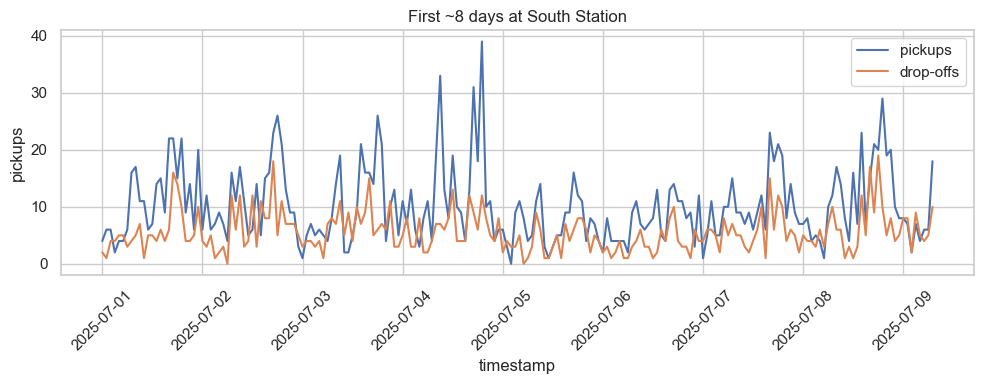

In [5]:
# Quick sanity check: demand distribution and a sample station profile
print(raw[["pickups", "dropoffs", "available_bikes"]].describe().round(2))

sample_station = "South Station"
sample = raw[raw["station_name"] == sample_station]
plt.figure(figsize=(10, 4))
sns.lineplot(data=sample.head(200), x="timestamp", y="pickups", label="pickups")
sns.lineplot(data=sample.head(200), x="timestamp", y="dropoffs", label="drop-offs")
plt.title(f"First ~8 days at {sample_station}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 2) Feature engineering
- Time encodings (hour/dow cyclic), weekend flag, month
- Weather, headways, 311 intensity, event score
- Lagged pickups/drop-offs/availability to capture momentum
- Station and neighborhood identity via dummies
- Targets: hourly pickups, drop-offs, and a stockout/overflow flag


In [6]:
def add_time_features(df: pd.DataFrame):
    df = df.copy()
    df["hour"] = df["timestamp"].dt.hour
    df["dow"] = df["timestamp"].dt.dayofweek
    df["is_weekend"] = df["dow"] >= 5
    df["month"] = df["timestamp"].dt.month
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    return df


def add_lags(df: pd.DataFrame, cols, lags=(1, 3, 6)):
    out = df.copy()
    for col in cols:
        for lag in lags:
            out[f"{col}_lag{lag}"] = out.groupby("station_id")[col].shift(lag)
    return out


df = add_time_features(raw)
df = add_lags(df, ["pickups", "dropoffs", "available_bikes", "available_docks", "net_flow", "stockout"])

# Keep raw labels for evaluation after one-hot encoding
df["neighborhood_raw"] = df["neighborhood"]
df["station_name_raw"] = df["station_name"]

# One-hot encode identity fields for tree models
encoded = pd.get_dummies(df, columns=["neighborhood", "station_name"], drop_first=False)

# Drop rows with insufficient history to compute lags
features_df = encoded.dropna().reset_index(drop=True)
print(features_df.head()[[
    "timestamp",
    "station_name_raw",
    "pickups",
    "pickups_lag1",
    "available_bikes_lag1",
    "precip_prob",
    "mbta_headway_min",
]])


            timestamp  station_name_raw  pickups  pickups_lag1  \
0 2025-07-01 06:00:00    Seaport Sq Hub        5          10.0   
1 2025-07-01 06:00:00     South Station        6           4.0   
2 2025-07-01 06:00:00     Copley Square        3           4.0   
3 2025-07-01 06:00:00  Fenway Lansdowne        4           2.0   
4 2025-07-01 06:00:00       MIT Kendall        4           5.0   

   available_bikes_lag1  precip_prob  mbta_headway_min  
0                  22.0     0.841178          7.666141  
1                  19.0     0.841178          7.666141  
2                  11.0     0.841178          7.666141  
3                  20.0     0.841178          7.666141  
4                   7.0     0.841178          7.666141  


## 3) Train/test split (time-aware)
Use the first 80% of the timeline for training and the final 20% for validation to avoid leakage from the future.


In [7]:
split_time = features_df["timestamp"].quantile(0.8)
train_df = features_df[features_df["timestamp"] < split_time].copy()
test_df = features_df[features_df["timestamp"] >= split_time].copy()

feature_drop_cols = [
    "timestamp",
    "latitude",
    "longitude",
    "pickups",
    "dropoffs",
    "stockout",
    "available_bikes",
    "available_docks",
    "net_flow",
    "neighborhood_raw",
    "station_name_raw",
]
feature_cols = [c for c in features_df.columns if c not in feature_drop_cols]

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

y_pick_train = train_df["pickups"]
y_pick_test = test_df["pickups"]
y_drop_train = train_df["dropoffs"]
y_drop_test = test_df["dropoffs"]
y_stock_train = train_df["stockout"].astype(int)
y_stock_test = test_df["stockout"].astype(int)

print(
    f"Train rows: {len(train_df):,}, Test rows: {len(test_df):,}, Features: {len(feature_cols)}"
)


Train rows: 8,004, Test rows: 2,004, Features: 56


## 4) Baselines
Two simple checks:
- *Persistence:* last-hour value per station
- *Seasonal median:* historical median for the same day-of-week and hour


In [8]:
def regression_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": root_mean_squared_error(y_true, y_pred),
    }


# Persistence baseline
baseline_pick = regression_metrics(y_pick_test, test_df["pickups_lag1"])
baseline_drop = regression_metrics(y_drop_test, test_df["dropoffs_lag1"])

# Seasonal median baseline
seasonal_pick = (
    train_df.groupby(["dow", "hour"])["pickups"].median().reindex(
        pd.MultiIndex.from_product([
            range(7),
            range(24),
        ]),
        fill_value=train_df["pickups"].median(),
    )
)
seasonal_drop = (
    train_df.groupby(["dow", "hour"])["dropoffs"].median().reindex(
        pd.MultiIndex.from_product([
            range(7),
            range(24),
        ]),
        fill_value=train_df["dropoffs"].median(),
    )
)

pickups_seasonal_pred = test_df.apply(
    lambda r: seasonal_pick.loc[(r["dow"], r["hour"])], axis=1
)
dropoffs_seasonal_pred = test_df.apply(
    lambda r: seasonal_drop.loc[(r["dow"], r["hour"])], axis=1
)

baseline_pick_seasonal = regression_metrics(y_pick_test, pickups_seasonal_pred)
baseline_drop_seasonal = regression_metrics(y_drop_test, dropoffs_seasonal_pred)

print(
    "Baseline MAE/RMSE",
    {
        "pickups_persistence": baseline_pick,
        "pickups_seasonal": baseline_pick_seasonal,
        "dropoffs_persistence": baseline_drop,
        "dropoffs_seasonal": baseline_drop_seasonal,
    },
)


Baseline MAE/RMSE {'pickups_persistence': {'MAE': 3.311377245508982, 'RMSE': 4.63002437882383}, 'pickups_seasonal': {'MAE': 2.5853293413173652, 'RMSE': 3.7415907042331598}, 'dropoffs_persistence': {'MAE': 2.094311377245509, 'RMSE': 2.7937233613156613}, 'dropoffs_seasonal': {'MAE': 1.6122754491017963, 'RMSE': 2.1519150826540745}}


## 5) Gradient-boosted models
Train LightGBM regressors for pickups/drop-offs and a classifier for stockout risk. Trees handle nonlinear interactions across weather, transit, lags, and station identity without heavy feature scaling.


In [9]:
gbm_params = dict(
    n_estimators=400,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.9,
    max_depth=-1,
    random_state=8,
)

pickup_model = LGBMRegressor(**gbm_params)
drop_model = LGBMRegressor(**gbm_params)
stock_model = LGBMClassifier(**gbm_params, class_weight="balanced")

pickup_model.fit(X_train, y_pick_train)
drop_model.fit(X_train, y_drop_train)
stock_model.fit(X_train, y_stock_train)

print("Models trained")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 8004, number of used features: 55
[LightGBM] [Info] Start training from score 6.074963
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1699
[LightGBM] [Info] Number of data points in the train set: 8004, number of used features: 55
[LightGBM] [Info] Start training from score 3.416792
[LightGBM] [Warning] Found whi

## 6) Evaluation
Compare gradient boosting to baselines, report per-neighborhood errors, and classification metrics for stockout/overflow risk.


In [10]:
test_df = test_df.copy()
test_df["pred_pickups"] = pickup_model.predict(X_test)
test_df["pred_dropoffs"] = drop_model.predict(X_test)

reg_eval = {
    "pickups_model": regression_metrics(y_pick_test, test_df["pred_pickups"]),
    "pickups_persistence": baseline_pick,
    "pickups_seasonal": baseline_pick_seasonal,
    "dropoffs_model": regression_metrics(y_drop_test, test_df["pred_dropoffs"]),
    "dropoffs_persistence": baseline_drop,
    "dropoffs_seasonal": baseline_drop_seasonal,
}
print("Regression metrics (MAE/RMSE):")
for k, v in reg_eval.items():
    print(f"  {k}: MAE={v['MAE']:.3f}, RMSE={v['RMSE']:.3f}")

# Neighborhood breakdown (MAE for pickups)
neigh_mae = (
    test_df.assign(abs_err=lambda d: (d["pred_pickups"] - d["pickups"]).abs())
    .groupby("neighborhood_raw")["abs_err"]
    .mean()
    .sort_values()
)
print("\nPickup MAE by neighborhood:")
print(neigh_mae.round(3))

# Stockout risk
test_df["stockout_proba"] = stock_model.predict_proba(X_test)[:, 1]
test_df["stockout_pred"] = (test_df["stockout_proba"] >= 0.5).astype(int)

roc = roc_auc_score(y_stock_test, test_df["stockout_proba"])
ap = average_precision_score(y_stock_test, test_df["stockout_proba"])
print(f"\nStockout classifier: ROC-AUC={roc:.3f}, AUPRC={ap:.3f}")
print(classification_report(y_stock_test, test_df["stockout_pred"], digits=3))


Regression metrics (MAE/RMSE):
  pickups_model: MAE=1.979, RMSE=2.656
  pickups_persistence: MAE=3.311, RMSE=4.630
  pickups_seasonal: MAE=2.585, RMSE=3.742
  dropoffs_model: MAE=1.433, RMSE=1.848
  dropoffs_persistence: MAE=2.094, RMSE=2.794
  dropoffs_seasonal: MAE=1.612, RMSE=2.152

Pickup MAE by neighborhood:
neighborhood_raw
Jamaica Plain         1.576
Allston               1.649
Dorchester            1.717
Roxbury               1.721
Somerville            1.777
Airport               1.905
Back Bay              2.021
Fenway                2.107
Cambridge             2.167
Seaport               2.350
Financial District    2.589
Name: abs_err, dtype: float64

Stockout classifier: ROC-AUC=0.701, AUPRC=0.923
              precision    recall  f1-score   support

           0      0.385     0.338     0.360       278
           1      0.895     0.913     0.904      1726

    accuracy                          0.833      2004
   macro avg      0.640     0.626     0.632      2004
weighted 

## 7) Interpretability with SHAP
Compute feature attributions for the stockout classifier and surface top drivers as human-readable rationales.


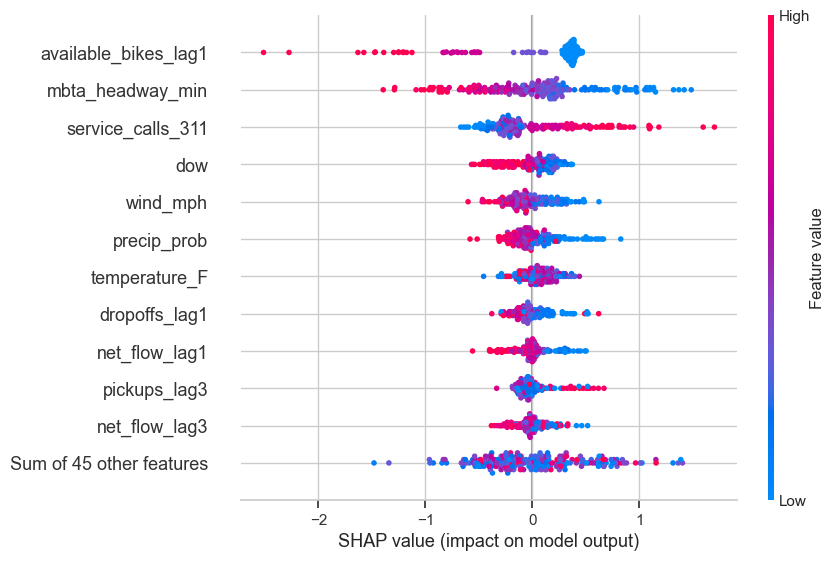

In [11]:
# Sample a manageable slice for plotting
sample_X = X_test.sample(min(200, len(X_test)), random_state=8)
stock_explainer = shap.TreeExplainer(stock_model)
stock_shap = stock_explainer(sample_X)

shap.plots.beeswarm(stock_shap, max_display=12)


In [12]:
friendly_names = {
    "available_bikes_lag1": "recent bikes available",
    "available_docks_lag1": "recent docks open",
    "pickups_lag1": "last hour pickups",
    "dropoffs_lag1": "last hour drop-offs",
    "pickups_lag3": "3h pickups",
    "dropoffs_lag3": "3h drop-offs",
    "net_flow_lag1": "last hour net flow",
    "precip_prob": "rain chance",
    "temperature_F": "temperature",
    "wind_mph": "wind",
    "mbta_headway_min": "MBTA headway",
    "service_calls_311": "311 activity",
    "event_score": "event pulse",
    "hour_sin": "time-of-day",
    "hour_cos": "time-of-day",
}


def rationale_from_shap(explanation, feature_names, top_k=3):
    vals = pd.Series(explanation.values, index=feature_names)
    top = vals.abs().sort_values(ascending=False).head(top_k)
    parts = []
    for feat in top.index:
        label = friendly_names.get(feat, feat)
        direction = "raises" if vals[feat] > 0 else "lowers"
        parts.append(f"{label} {direction} risk ({vals[feat]:+.2f})")
    return "; ".join(parts)

example_rationale = rationale_from_shap(stock_explainer(X_test.iloc[[0]])[0], feature_cols)
print("Example rationale:\n", example_rationale)


Example rationale:
 MBTA headway lowers risk (-0.88); dropoffs_lag6 raises risk (+0.51); pickups_lag6 raises risk (+0.41)


## 8) Rebalancing recommendations
Forecast one hour ahead for each station using the latest known state, flag shortages/overflows, and attach textual rationales derived from SHAP.


In [13]:
# Build a next-hour scenario from the latest observed hour per station
future = features_df.sort_values("timestamp").groupby("station_id").tail(1).copy()
future["timestamp"] = future["timestamp"] + pd.Timedelta(hours=1)
future = add_time_features(future)

X_future = future[feature_cols]
future["pred_pickups"] = pickup_model.predict(X_future)
future["pred_dropoffs"] = drop_model.predict(X_future)
future["stockout_proba"] = stock_model.predict_proba(X_future)[:, 1]
future_shap = stock_explainer(X_future)

plans = []
for idx, row in future.iterrows():
    predicted_bikes = row["available_bikes"] - row["pred_pickups"] + row["pred_dropoffs"]
    shortage = max(0, int(np.ceil(0.25 * row["capacity"] - predicted_bikes)))
    overflow = max(0, int(np.ceil(predicted_bikes - 0.9 * row["capacity"])))

    if shortage > 0:
        action = f"Deliver {shortage} bikes"
    elif overflow > 0:
        action = f"Remove {overflow} bikes"
    else:
        action = "Monitor"

    rationale = rationale_from_shap(future_shap[future.index.get_loc(idx)], feature_cols, top_k=3)

    plans.append(
        {
            "timestamp": row["timestamp"],
            "station": row["station_name_raw"],
            "neighborhood": row["neighborhood_raw"],
            "capacity": row["capacity"],
            "current_bikes": int(row["available_bikes"]),
            "pred_pickups": row["pred_pickups"],
            "pred_dropoffs": row["pred_dropoffs"],
            "predicted_bikes": predicted_bikes,
            "stockout_prob": row["stockout_proba"],
            "action": action,
            "rationale": rationale,
        }
    )

plan_df = pd.DataFrame(plans)
plan_df = plan_df.sort_values("stockout_prob", ascending=False)
plan_df[[
    "timestamp",
    "station",
    "neighborhood",
    "current_bikes",
    "pred_pickups",
    "pred_dropoffs",
    "predicted_bikes",
    "stockout_prob",
    "action",
    "rationale",
]].head(10).style.format({
    "pred_pickups": "{:.1f}",
    "pred_dropoffs": "{:.1f}",
    "predicted_bikes": "{:.1f}",
    "stockout_prob": "{:.2f}",
})



,timestamp,station,neighborhood,current_bikes,pred_pickups,pred_dropoffs,predicted_bikes,stockout_prob,action,rationale
11,2025-08-05 00:00:00,JP Centre,Jamaica Plain,1,2.3,1.6,0.3,0.92,Deliver 7 bikes,recent bikes available raises risk (+0.43); dropoffs_lag6 raises risk (+0.31); wind raises risk (+0.27)
8,2025-08-05 00:00:00,Seaport Sq Hub,Seaport,0,4.8,2.6,-2.2,0.88,Deliver 11 bikes,311 activity lowers risk (-0.62); recent bikes available raises risk (+0.41); dropoffs_lag6 raises risk (+0.32)
6,2025-08-05 00:00:00,Copley Square,Back Bay,0,3.9,2.6,-1.2,0.87,Deliver 9 bikes,311 activity lowers risk (-0.47); recent bikes available raises risk (+0.43); dropoffs_lag6 raises risk (+0.28)
7,2025-08-05 00:00:00,South Station,Financial District,0,4.3,3.8,-0.5,0.87,Deliver 12 bikes,dropoffs_lag6 raises risk (+1.08); 311 activity lowers risk (-0.67); recent bikes available raises risk (+0.33)
2,2025-08-05 00:00:00,Fields Corner,Dorchester,0,1.8,1.3,-0.5,0.86,Deliver 7 bikes,recent bikes available raises risk (+0.46); wind raises risk (+0.30); 311 activity lowers risk (-0.23)
1,2025-08-05 00:00:00,Logan Connector,Airport,0,2.7,1.7,-1.0,0.83,Deliver 7 bikes,net_flow_lag6 raises risk (+0.33); 311 activity lowers risk (-0.26); temperature raises risk (+0.25)
9,2025-08-05 00:00:00,Allston Harvard Ave,Allston,4,3.1,2.5,3.4,0.80,Deliver 4 bikes,recent bikes available raises risk (+0.39); 311 activity lowers risk (-0.35); temperature raises risk (+0.23)
5,2025-08-05 00:00:00,Fenway Lansdowne,Fenway,0,2.8,2.3,-0.5,0.77,Deliver 8 bikes,311 activity lowers risk (-0.60); pickups_lag6 raises risk (+0.52); recent bikes available raises risk (+0.35)
0,2025-08-05 00:00:00,Assembly Row,Somerville,1,2.6,1.7,0.1,0.63,Deliver 6 bikes,311 activity lowers risk (-0.20); hour lowers risk (-0.18); MBTA headway lowers risk (-0.16)
10,2025-08-05 00:00:00,MIT Kendall,Cambridge,0,3.4,3.3,-0.1,0.62,Deliver 9 bikes,311 activity lowers risk (-0.50); recent bikes available raises risk (+0.35); wind raises risk (+0.24)
